In [1]:
import principal_portfolios as pp
import utils
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from functools import reduce

### Reading MS data and Merging portfolio data into a dataframe.

In [2]:
data_to_read_address = "data/FX/Portfolio/MSFX.xlsx"
fx_ms_df = pd.read_excel(data_to_read_address)

dfs = []

# Loop through the dataframe, two columns at a time (one for date, one for value)
for i in range(0, len(fx_ms_df.columns), 2):
    date_col = fx_ms_df.columns[i]
    value_col = fx_ms_df.columns[i + 1]
    
    # Rename the columns for clarity
    instrument_name = date_col.replace(' Index', '')
    
    # Create a new dataframe for the current instrument
    temp_df = fx_ms_df[[date_col, value_col]].copy()
    temp_df.columns = ['date', instrument_name]
    
    # Remove rows where the date is NaT or NaN in both columns
    temp_df = temp_df.dropna(subset=['date', instrument_name])
    
    # Append the dataframe to the list
    dfs.append(temp_df)

# Perform an inner join on the 'date' column for all dataframes
merged_ms_prtf_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

# Remove any remaining rows with NaT or NaN after merging
merged_ms_prtf_df.dropna(inplace=True)
merged_ms_prtf_df = utils.construct_monthly_return_FX_portfolios_datasets(merged_ms_prtf_df)

### Reading DB data

In [3]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_1.xlsx"
db_data_df_1= pd.read_excel(data_to_read_address)
db_data_df_1.dropna(inplace=True)
monthly_db_1_returns = utils.construct_monthly_return_FX_portfolios_datasets(db_data_df_1)

In [4]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_2.xlsx"
db_data_df_2= pd.read_excel(data_to_read_address)
db_data_df_2.dropna(inplace=True)
monthly_db_2_returns = utils.construct_monthly_return_FX_portfolios_datasets(db_data_df_2)

In [5]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_3.xlsx"
db_data_df_3= pd.read_excel(data_to_read_address)
db_data_df_3.dropna(inplace=True)
monthly_db_3_returns = utils.construct_monthly_return_FX_portfolios_datasets(db_data_df_3)

In [6]:
data_to_read_address = "data/FX/Portfolio/DB_FX_PRTF_4.xlsx"
db_data_df_4= pd.read_excel(data_to_read_address)
db_data_df_4.dropna(inplace=True)
monthly_db_4_returns = utils.construct_monthly_return_FX_portfolios_datasets(db_data_df_4)

In [7]:
dfs = [merged_ms_prtf_df, monthly_db_1_returns, monthly_db_2_returns, monthly_db_3_returns, monthly_db_4_returns]

# Perform inner join on 'id' column for all DataFrames
basket_portfolios = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

#### Deleting the columns that are more than 98 percent correlated.

In [8]:
basket_portfolios = utils.exclude_redundant_columns_FX_portfolios_datasets(basket_portfolios)

## Principal Portfolio Analysis 

dict_keys(['fx_ms_portfolio_momentum_monthly'])
dict_keys(['realized_returns_df', 'sharpe_df', 'pp_realized_mean_df', 'pp_expected_mean_df', 'pep_realized_mean_df', 'pep_expected_mean_df', 'pap_realized_mean_df', 'pap_expected_mean_df'])
return_of_simple_factor          -0.206855
realized_return_of_first_n_PP     0.122129
realized_return_of_first_n_PEP    0.599447
realized_return_of_last_n_PEP    -0.129695
long_short_realized_PEP           0.646062
                                    ...   
realized_return_of_16_PAP        -0.124893
realized_return_of_17_PAP        -0.047673
realized_return_of_18_PAP        -0.081146
realized_return_of_19_PAP         0.672608
PEP and PAP 1-n                   0.918438
Length: 104, dtype: float64


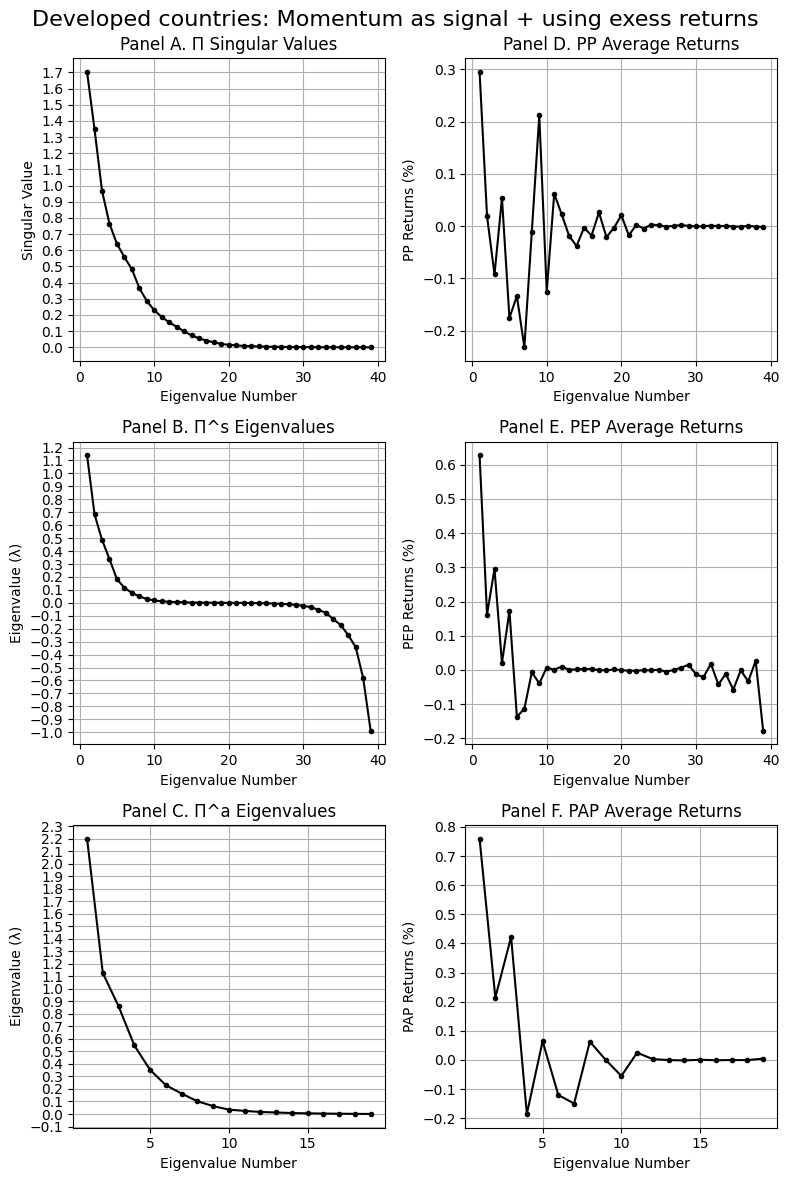

In [10]:
starting_year_to_filter = 1996
end_year_to_filter = 2024
number_of_lookback_periods = 120
number_of_PPs_to_consider = 3
number_of_PEPs_to_consider = 3
number_of_PAPs_to_consider = 3
output_dict_momentum = {}


basket_portfolios['date'] = utils.convert_date_column_for_monthly_data(basket_portfolios)
signal_df = utils.build_signal_df_for_1month_momentum(basket_portfolios)



portfolios_key = "fx_ms_portfolio_momentum_monthly"
output_dict_momentum[portfolios_key] = pp.build_PP(basket_portfolios,signal_df,
                                                                   number_of_lookback_periods,starting_year_to_filter,end_year_to_filter,
                                                                   factor_data_monthly=None, number_of_PPs_to_consider=number_of_PPs_to_consider,
                                                                   number_of_PEPs_to_consider=number_of_PEPs_to_consider, 
                                                                   number_of_PAPs_to_consider= number_of_PAPs_to_consider)

# I calculate the results for all datasets. the results are stored in this dictionay.
print(output_dict_momentum.keys())
'''
Every value of this dictionary is itself another dictionary.
For instance the key 'sharpe_df' can be used to access the sharp values of this set of results.
'''
print(output_dict_momentum[portfolios_key].keys())
print(output_dict_momentum[portfolios_key]["sharpe_df"])

number_of_portfolios = basket_portfolios.shape[1]
title = 'Developed countries: Momentum as signal + using exess returns'

pp.singular_values_vs_realized_returns_graph(output_dict_momentum, portfolios_key, number_of_portfolios, title)

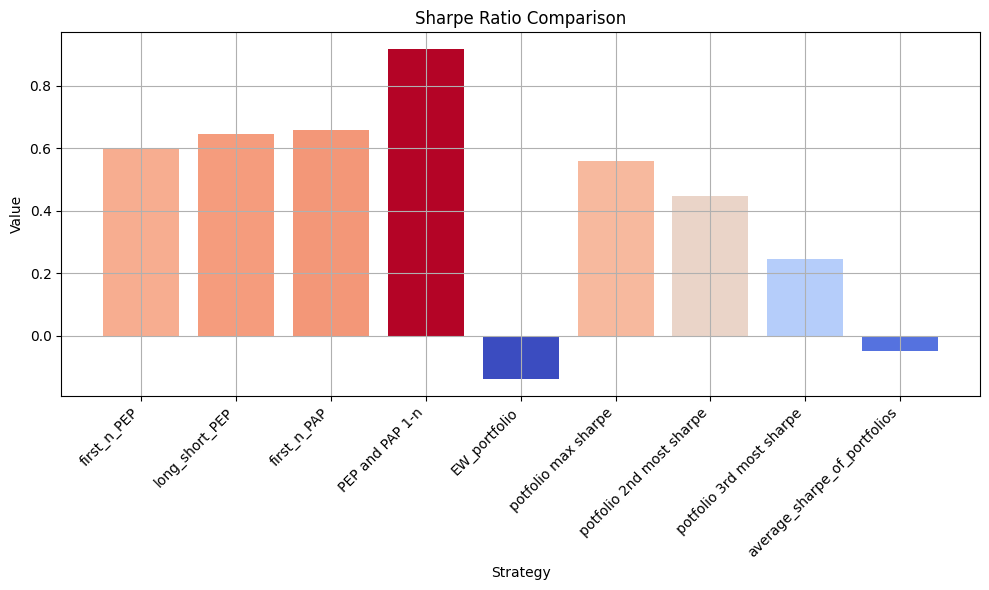

In [38]:
equal_weighted_portfolio = pp.calculate_sharpe_ratio(basket_portfolios.iloc[number_of_lookback_periods:,1:].mean(axis=1)) * math.sqrt(12)
sharpe_of_individual_portfolios = basket_portfolios.iloc[number_of_lookback_periods:,1:].apply(lambda col: pp.calculate_sharpe_ratio(col)) * math.sqrt(12)
individual_portfolios_with_max = sharpe_of_individual_portfolios.sort_values(ascending=False)[0:3]

# List of values
values = [output_dict_momentum[portfolios_key]["sharpe_df"]['realized_return_of_first_n_PEP'],
          output_dict_momentum[portfolios_key]["sharpe_df"]['long_short_realized_PEP'],
          output_dict_momentum[portfolios_key]["sharpe_df"]['realized_return_of_first_n_PAP'],
          output_dict_momentum[portfolios_key]["sharpe_df"]['PEP and PAP 1-n'],
          equal_weighted_portfolio,
          individual_portfolios_with_max[0],
          individual_portfolios_with_max[1],
          individual_portfolios_with_max[2],
          sharpe_of_individual_portfolios.mean()
         ]

# List of labels for the x-axis
labels = ['first_n_PEP', 'long_short_PEP', 'first_n_PAP', 'PEP and PAP 1-n', 'EW_portfolio',
          'potfolio max sharpe', 'potfolio 2nd most sharpe', 'potfolio 3rd most sharpe',
          'average_sharpe_of_portfolios'

          ]

plt.figure(figsize=(10, 6)) 
# Normalize the values between 0 and 1
norm_values = (np.array(values) - min(values)) / (max(values) - min(values))

# Get a colormap (from red to blue)
cmap = plt.get_cmap('coolwarm')  # You can use other colormaps like 'viridis', 'plasma', etc.

# Create a list of colors based on the normalized values
colors = cmap(norm_values)

# Create the bar chart with the gradient colors
plt.bar(labels, values, color=colors)

# Add labels and title (optional)
plt.xlabel('Strategy')
plt.ylabel('Value')
plt.title('Sharpe Ratio Comparison')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them for better visibility

# Display the bar chart
plt.tight_layout()  # Adjust layout to ensure everything fits well
# Display the bar chart
plt.show()
